In [51]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
image_dir = 'flickr8k/images'
caption_file = 'flickr8k/captions.txt'

captions = pd.read_csv(caption_file, delimiter='|')['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)

Vocab size: 8829


In [40]:
# train word2vec
from gensim.models.word2vec import Word2Vec

word2vec_model = Word2Vec([word_tokenize(caption) for caption in captions], vector_size=256, window=5, min_count=1, workers=4)

In [ ]:
# train word2vec
from gensim.models.word2vec import Word2Vec

word2vec_model = Word2Vec([word_tokenize(caption) for caption in captions], vector_size=256, window=5, min_count=1, workers=4)

In [49]:
# extract indices of words
idx2word = word2vec_model.wv.index_to_key
word2idx = {word: idx for idx, word in enumerate(idx2word)}

In [34]:
# create pytorch nn embedding layer
"""
embedding = torch.nn.Embedding(word2vec_model.wv.vectors.shape[0], word2vec_model.wv.vectors.shape[1])
embedding.weight.data.copy_(torch.from_numpy(word2vec_model.wv.vectors))
embedding.weight.requires_grad = False
"""

In [53]:
# create embedding layer from scratch
from collections import OrderedDict

vocab = OrderedDict()
vocab['<pad>'] = None
vocab['<sos>'] = None
vocab['<eos>'] = None
vocab['<unk>'] = None

special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens

for caption in captions:
    for word in special_word_tokenizer.tokenize(caption):
        if word not in vocab:
            vocab[word] = None

idx2word = list(vocab.keys())
word2idx = {word: idx for idx, word in enumerate(idx2word)}

idx2word[:10]

['<pad>', '<sos>', '<eos>', '<unk>', 'a', 'child', 'in', 'pink', 'dress', 'is']

In [59]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, tokenizer, word2idx, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the txt file with captions.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, delimiter='|')
        self.transform = transform
        self.tokenizer = tokenizer
        self._last_img = (None, None)
        # clean caption_text
        self.df['caption_text'] = self.df['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)
        # append <start> and <end> to caption_text
        self.df['caption_text'] = self.df['caption_text'].apply(lambda x: '<sos> ' + x + ' <eos>')
        self.word2idx = word2idx

    def _caption_to_idx(self, caption):
        return [self.word2idx[word] for word in self.tokenizer(caption)]
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        if self._last_img[0] == img_name:
            image = self._last_img[1]
        else:
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            self._last_img = (img_name, image)

        caption_number = self.df.iloc[idx, 1]
        caption = self.df.iloc[idx, 2]
        
        # encode caption
        caption_idx = self._caption_to_idx(caption)

        return image, caption_number, caption_idx, caption


dataset = Flickr8kDataset(image_dir, caption_file, special_word_tokenizer.tokenize, word2idx)
print(len(dataset))

40455


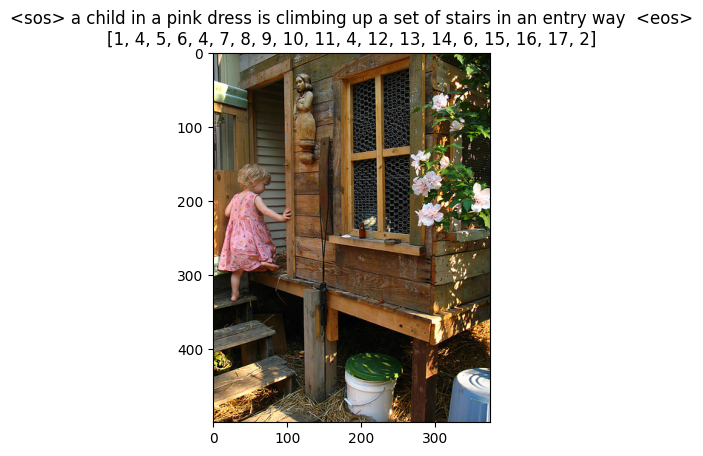

In [60]:
# display the first sample
im = dataset[0][0]
caption_idx = dataset[0][2]
caption = dataset[0][3]

plt.imshow(im)
plt.title(caption + '\n' + str(caption_idx))
plt.show()

In [38]:
# analyze the image sizes
sizes = []
for im, idx, _ in tqdm(dataset):
    if idx == 0:
        sizes.append(im.size)

sizes = np.array(sizes)
print(sizes.shape)

100%|██████████| 40455/40455 [00:17<00:00, 2264.73it/s]

(8091, 2)


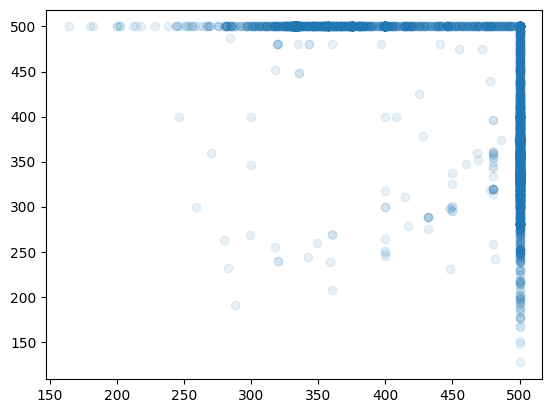

In [39]:
# plot the image sizes
plt.scatter(sizes[:, 0], sizes[:, 1], alpha=0.1)

# Model

In [83]:
import torch.nn as nn
from torchvision import models

from typing import Tuple


class Encoder(nn.Module):

    def __init__(self, image_embedding_dim: int, device: torch.device):
        super(Encoder, self).__init__()
        self.image_embedding_dim = image_embedding_dim
        self.device = device

        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        self.fc = nn.Linear(resnet.fc.in_features, self.image_embedding_dim)


    def forward(self, images: torch.Tensor) -> torch.Tensor:
        x = self.resnet(images)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
    

class Decoder(nn.Module):

    def __init__(self, image_embedding_dim: int, word_embedding_dim: int, lstm_layers: int, vocabulary_size: int, device: torch.device):
        super(Decoder, self).__init__()
        self.image_embedding_dim = image_embedding_dim
        self.word_embedding_dim = word_embedding_dim
        self.lstm_layers = lstm_layers
        self.vocabulary_size = vocabulary_size
        self.device = device
        lstm_input_size = self.image_embedding_dim + self.word_embedding_dim

        self.hidden_state_0 = nn.Parameter(torch.zeros((self.lstm_layers, 1, lstm_input_size), device=self.device))
        self.cell_state_0 = nn.Parameter(torch.zeros((self.lstm_layers, 1, lstm_input_size), device=self.device))


        self.lstm = nn.LSTM(input_size = lstm_input_size,
                            hidden_size = lstm_input_size,
                            num_layers = self.lstm_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(lstm_input_size, self.vocabulary_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, embedded_captions: torch.Tensor, features: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

        lstm_input = torch.cat((features, embedded_captions), dim=2)

        lstm_output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        output = self.fc(lstm_output)

        return output, (hidden, cell)

image_encoder = Encoder(256, torch.device('cpu'))
embedding_layer = nn.Embedding(len(vocab), 256, padding_idx=word2idx['<pad>'])
caption_decoder = Decoder(256, 256, 1, len(vocab), torch.device('cpu'))

# create random tensor of images and captions 
images = torch.randn(32, 3, 500, 500)
# sequence of 40 words
captions = torch.randint(0, len(vocab), (32, 40))
print("captions:", captions.size())

# encode images
image_features = image_encoder(images).unsqueeze(0).repeat(40, 1, 1)
print("image_features:", image_features.size())

# embed captions
embedded_captions = embedding_layer(captions).permute(1, 0, 2)
print("embedded_captions:", embedded_captions.size())

# initialize hidden and cell states
hidden = caption_decoder.hidden_state_0.repeat(1, 32, 1)
cell = caption_decoder.cell_state_0.repeat(1, 32, 1)

print("hidden:", hidden.size())
print("cell:", cell.size())


# decode
outputs, (hidden, cell) = caption_decoder(embedded_captions, image_features, hidden, cell)

print("outputs:", outputs.size())
print("hidden:", hidden.size())
print("cell:", cell.size())

captions: torch.Size([32, 40])
image_features: torch.Size([40, 32, 256])
embedded_captions: torch.Size([40, 32, 256])
hidden: torch.Size([1, 32, 512])
cell: torch.Size([1, 32, 512])
outputs: torch.Size([40, 32, 8832])
hidden: torch.Size([1, 32, 512])
cell: torch.Size([1, 32, 512])


In [86]:

# convert outputs to captions_idx
captions = torch.argmax(outputs, dim=2)
print("captions:", captions.size())

# convert captions_idx to captions
captions = [[idx2word[idx.item()] for idx in caption] for caption in captions]
print("captions:", captions[0])

captions: torch.Size([40, 32])
captions: ['greets', 'typical', 'surroundings', 'gauges', 'backed', 'widelegged', 'starring', 'chiseling', 'slab', 'nearby', 'shaded', 'sky', 'clue', 'heritage', 'glove', 'dangles', 'lopes', 'sabre', 'cot', 'spot', 'shivers', 'drumming', 'leash', 'drainpipe', 'coats', 'outise', 'establishment', 'butts', 'slope', 'chairs', 'engaged', 'ceiling']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


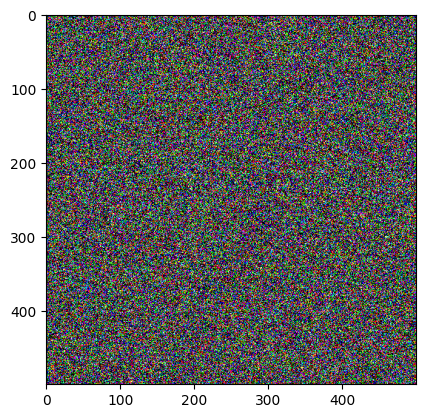

In [87]:
# visualize the first image
plt.imshow(images[0].permute(1, 2, 0))